---
# **データサイエンス基礎　第7回課題**
## **【回帰分析】最高気温と電力需要の単回帰分析および多項式回帰分析**
---
### 1. データの概要
　今回扱うデータは，[気象庁の過去の気象データ](https://www.data.jma.go.jp/gmd/risk/obsdl/index.php)より得られる埼玉県熊谷市の気象データと，[東京電力パワーグリッド株式会社が公表する過去の電力使用実績データ](https://www.tepco.co.jp/forecast/)より得られる東京エリアの電力使用実績データを，それぞれのSheetに記述し，1つのExcelファイルとしてまとめたものである．
> [https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx](https://github.com/KHiraGit/sudspg_ds/raw/main/ds07_temp_power_exercise.xlsx)  
  
　このExcel形式のデータを処理して，最高気温と電力需要の単回帰分析および多項式回帰分析を行う．
### 2. 2020年1月の最高気温と電力需要の単回帰分析および多項式回帰分析
　まず，各シートの1行目に関して，今回タイトルとして扱いたい情報が含まれない．したがって，1行目を無視する必要がある．また，2，3行目もタイトル行として扱うには不備があり，扱いにくい．以上より，1，2，3行目を無視し，データフレームのタイトル行は自分で定義する必要があると考えられる．  
　また，電力需要のデータは，1日の1時間毎にデータが記録されている．したがって，この平均値をとり，その日の電力需要とする必要がある．  
　加えて，プログラムの汎用化のために，最高気温だけでなく他の気象データと電力需要の回帰分析も行えるように工夫する．  
　回帰分析には，Pythonライブラリのscikit-learnを用いる．scikit-learnは，機械学習のためのPythonライブラリで，線形回帰やリッジ回帰，ラッソ回帰など，さまざまな回帰モデルが提供されている．

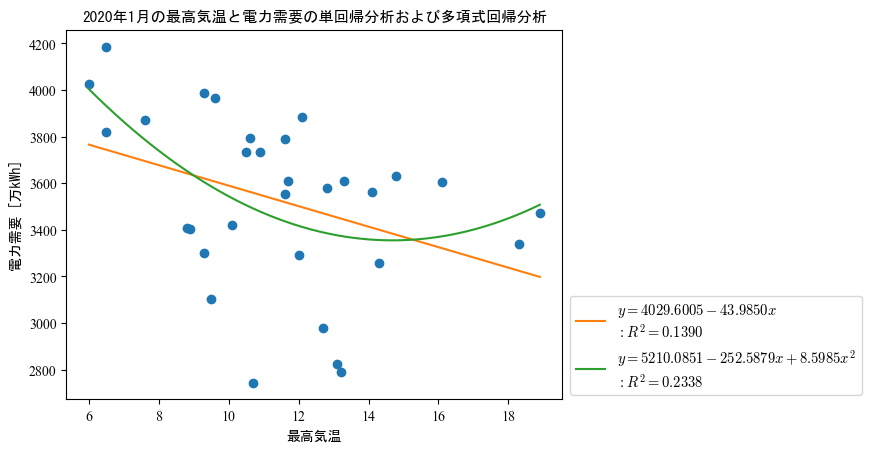

In [3]:
# ライブラリの読み込み
# %pip install --upgrade pip
# %pip install numpy
# %pip install matplotlib
# %pip install pandas
# %pip install openpyxl
# %pip install sympy
# %pip install scipy
# %pip install re
# %pip install jaconv
# %pip install scikit-learn
from matplotlib.font_manager import FontProperties
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import random
import sympy as sp
import scipy.stats as stats
import re
import jaconv 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression


# 変数の定義
year = 2020             # 対象年度
month = 1               # 対象月
X_name = '最高気温'     # 対象気象データ名（従属変数名）


# 気象データのExcel Sheetの読み込み
df_weather = pd.read_excel( 'ds07_temp_power_exercise.xlsx', 
                        sheet_name='2020熊谷市気象データ_data', skiprows=[0,1,2],
                        names= ['年月日', '平均気温', '', '', '最高気温', '', '', '', '', '最低気温', '', '', '', '', 
                                '降水量', '', '', '', '日照時間', '', '', '', '降雪量', '', '', '', '平均風速', '', '', 
                                '平均蒸気圧', '', '', '平均湿度', '', '', '平均現地気圧', '', '', '', '', '', '天気概況', '', ''])
df_weather['年月日'] = pd.to_datetime(df_weather['年月日'], format='%Y/%m/%d')

# 電力需要データのExcel Sheetの読み込み
df_power = pd.read_excel('ds07_temp_power_exercise.xlsx', 
                        sheet_name='東京電力パワーグリッド エリア需給実績データ', skiprows=[0,1],
                        names=['年月日', '時間', '電力需要', '', '', '', '', '', '', '', '', '', '', '', ''])
df_power['年月日'] = pd.to_datetime(df_power['年月日'], format='%Y/%m/%d')



# 対象データの抽出（X：独立変数，Y：従属変数）
X_weather = df_weather[(df_weather['年月日'].dt.year == year) & (df_weather['年月日'].dt.month == month)][[X_name]]
Y_power = df_power[(df_power['年月日'].dt.year == year) & (df_power['年月日'].dt.month == month)]\
        .groupby(df_power['年月日'])['電力需要'].mean().reset_index()
Y_power = Y_power['電力需要']
pf = PolynomialFeatures(degree=2)
X_poly = pf.fit_transform(X_weather)

# 単回帰分析(Simple Regression Analysis)
SRA = LinearRegression()
SRA.fit(X_weather, Y_power)
legend_SRA = rf'$y = {SRA.intercept_:.4f} {SRA.coef_[0]:+.4f} x$' + '\n' + rf'$: R^2 = {SRA.score(X_weather, Y_power):.4f}$'

# 多項式回帰分析(Polynomial Regression Analysis)
PRA = LinearRegression()
PRA.fit(X_poly, Y_power)
legend_PRA = rf'$y = {PRA.intercept_:.4f} {PRA.coef_[1]:+.4f} x {PRA.coef_[2]:+.4f} x^2$' + '\n' + rf'$: R^2 = {PRA.score(X_poly, Y_power):.4f}$'

# データの散布図を作成
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(X_weather, Y_power, 'o')

# 単回帰直線を描画
linspace = pd.DataFrame(np.linspace(X_weather.min(), X_weather.max(), 100), columns=[X_name])
ax1.plot(linspace, SRA.predict(linspace), label=legend_SRA)

# 多項式回帰曲線を描画
linspace_pf = pf.fit_transform(linspace)
ax1.plot(linspace, PRA.predict(linspace_pf), label=legend_PRA)
ax1.legend(loc='upper center', bbox_to_anchor=(1.31, 0.3), prop={'size': 10.5})


# グラフの設定
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel(X_name, fontproperties={'family':'MS Gothic'})
plt.ylabel('電力需要 [万kWh]', fontproperties={'family':'MS Gothic'})
plt.title(f'{year}年{month}月の{X_name}と電力需要の単回帰分析および多項式回帰分析', fontproperties={'family':'MS Gothic'}, size=11)
plt.show()

　単回帰分析の結果より，最高気温と電力需要には，非常に弱い負の相関があることが示唆された．しかし，データは1月におけるもののみであり，年間における全てのデータでは，結果が異なる可能性がある．  
　負の相関関係より，最高気温が低い日ほど，電力需要が高まり，最高気温が高い日ほど，電力需要が低くなることがいえる．これは，1月（冬の時期）の中でも，最高気温の低い日（寒い日）に，空調などの暖房器具のための電力需要が高まるためであると考えられる．  
　この結果より，8月（夏の時期）の結果は，これと逆となり，正の相関が見られることが予測される．グラフなどは掲載しないが，実際に8月の場合を試し，正の相関が見られることが確認できた．したがって，年間では，電力需要がV字状あるいは放物線状に描かれることが考えられ，次節ではこれを確認する．

### 3. 2020年の最高気温と電力需要の単回帰分析および多項式回帰分析
　2. と同様に，電力需要のデータに関しては，1時間毎のデータの平均値をとり，その日の電力需要とする．加えて，プログラムの汎用化のために，最高気温だけでなく他の気象データと電力需要の回帰分析も行えるように工夫する．回帰分析には，Pythonライブラリのscikit-learnを用いる．

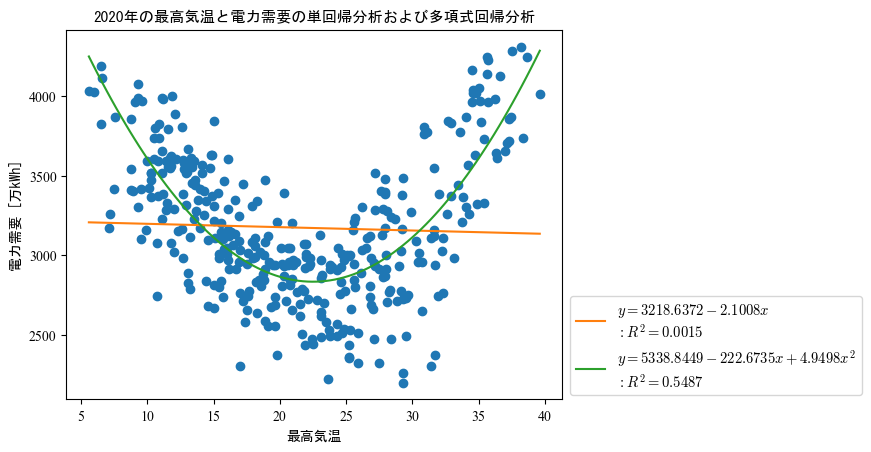

In [4]:
# 変数の定義
year = 2020             # 対象年度
X_name = '最高気温'     # 対象気象データ名（従属変数名）


# 対象データの抽出（X：独立変数，Y：従属変数）
X_weather = df_weather[(df_weather['年月日'].dt.year == year)][[X_name]]
Y_power = df_power[(df_power['年月日'].dt.year == year)].groupby(df_power['年月日'])['電力需要'].mean().reset_index()
Y_power = Y_power['電力需要']
pf = PolynomialFeatures(degree=2)
X_poly = pf.fit_transform(X_weather)

# 単回帰分析(Simple Regression Analysis)
SRA = LinearRegression()
SRA.fit(X_weather, Y_power)
legend_SRA = rf'$y = {SRA.intercept_:.4f} {SRA.coef_[0]:+.4f} x$' + '\n' + rf'$: R^2 = {SRA.score(X_weather, Y_power):.4f}$'

# 多項式回帰分析(Polynomial Regression Analysis)
PRA = LinearRegression()
PRA.fit(X_poly, Y_power)
legend_PRA = rf'$y = {PRA.intercept_:.4f} {PRA.coef_[1]:+.4f} x {PRA.coef_[2]:+.4f} x^2$' + '\n' + rf'$: R^2 = {PRA.score(X_poly, Y_power):.4f}$'

# データの散布図を作成
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(X_weather, Y_power, 'o')

# 単回帰直線を描画
linspace = pd.DataFrame(np.linspace(X_weather.min(), X_weather.max(), 100), columns=[X_name])
ax1.plot(linspace, SRA.predict(linspace), label=legend_SRA)

# 多項式回帰曲線を描画
linspace_pf = pf.fit_transform(linspace)
ax1.plot(linspace, PRA.predict(linspace_pf), label=legend_PRA)
ax1.legend(loc='upper center', bbox_to_anchor=(1.31, 0.3), prop={'size': 10.5})


# グラフの設定
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.xlabel(X_name, fontproperties={'family':'MS Gothic'})
plt.ylabel('電力需要 [万kWh]', fontproperties={'family':'MS Gothic'})
plt.title(f'{year}年の{X_name}と電力需要の単回帰分析および多項式回帰分析', fontproperties={'family':'MS Gothic'}, size=11)
plt.show()

　したがって，データが増えると，ばらつきはあるものの，下に凸の放物線上にプロットされることが確認できる．これは電力需要 $y$ が最高気温 $x$ の2乗に比例することを意味する．また，最高気温と電力需要の相関に関する重要な要因として，”空調にかかる電力”が挙げられる．したがって，最高気温が高い（暑い）日は，冷房にかかる電力，最高気温が低い（寒い）日は，暖房にかかる電力の影響が大きく起因して，$電力需要 \propto 最高気温^2$ という結果が得られたものと考えられる．  
　また，多項式回帰分析の結果より得られた数式は次式である．  
$$y = 4.9498 x^2 - 222.6735 x + 5338.8449$$  
これを変形し，係数も概数で表現すれば，次式のようになる．  
$$y = 5 (x + 22.5)^2 + 2835$$  
　したがって，気温がおよそ22.5℃のとき，電力需要が最小値をとることが分かる．これより，電力需要的に考察すれば，22.5℃付近が最も快適な温度であるといえる．

### 感想  
　回帰分析より，データ同士の単純な相関関係を確認するだけでなく，次数相関を推定できることが分かった．その結果より，物理的に考えられる理論式を推定することができると面白いと感じた．また，回帰分析はデータの大まかな相関関係を見ることに役立つため，同じく相関関係の確認の際に用いられるペアプロットなどと併せて用いることで，よりデータの相関を視覚化あるいは定量化することができると感じた．
　